# Apartments.com NLP 

Hello, Audrey here. I'm scraping 500 listings from www.apartments.com for four neighborhoods: East Hollywood, Boyle Heights, Koreatown, and Highland Park. Each listing includes a description as well as three types of amenities (Unique Amenities, Apartment Features, and Community Amenities). I found the word frequencies for each. 

I know I need to remove the outliers given that a small sample of 25 listings in East Hollywood shows that some listings fall outside of the neighborhood boundaries. I haven't gotten to that for the 500 listing dfs (it takes quite a bit of time to run), but I'm thinking I'll create a function that takes a df of scraped listings as a parameter, and (1) adds a geometry column using the scraped lat/long, and (2) returns a map of the listings. 

I also scraped the "Pricing & Floor Plans" sections that provides available unit type and rents. Sara and I want to do some kind of analysis that compares across neighborhoods' rents and their gentrification word frequencies. I'm a bit lost on how to go about cleaning this information to be easily digestible -- I was thinking of calculating PSF rents for each listing, but also still have to think through how to do that within the dataframe ("BR", "unit_type", and "rents" columns).

Example apartments.com listing: https://www.apartments.com/lido-apartments-los-angeles-ca/9nkznr5/ 

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
import requests
from bs4 import BeautifulSoup

In [4]:
import time
import random

In [5]:
import re

## Scrape the posts  (UPDATED with latlon and unit mix/rent breakdowns)


In [6]:
def getPosts(neighborhood, howmany):
    postList = []
    n = neighborhood.replace(' ', '-')
    
    # range 0 (1st page) - number of posts you want, going up in 120 increments 
    ## looping over the pages until you reach the target HOWMANY posts 
    for i in range(0, howmany, 25): 
        print(i)
        
##### FOR EACH PAGE: 
        # insert neighborhood and number of posts to scrape 
        url = f'https://www.apartments.com/{n}-los-angeles-ca/{i}/'  
        
        #request the text from the url 
        time.sleep(random.random()*5)
        r =requests.get(url, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"})
        soup = BeautifulSoup(r.content)

        #get a list of posts 
        posts = soup.find_all('li', class_="mortar-wrapper")
        
        #FOR EACH POST 
        for post in posts: 
            #name
            name = post.find('span', class_="js-placardTitle title")
            if name is not None: 
                name = name.text 
            
            #address
            addy = post.find('div', class_="property-address js-url")
            if addy is not None: 
                addy = addy.text 

            #price 
            price = post.find('div', class_= "price-range")
            if price is not None: 
                price = price.text  
            
            #unit type - each post has a table of unit type and price, do that in another function
            beds = post.find('div', class_="bed-range")   
            if beds is not None:
                beds = beds.text  

##### INDIVIDUAL LISTING 
            #go into the individual post's url 
            url_post = post.find('a', class_="property-link")['href']
            time.sleep(random.random()*7)
            r_post = requests.get(url_post, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"})
            soup_post = BeautifulSoup(r_post.content)
            
            #unit mix, rents 
            BR = soup_post.find_all('div', class_ = "priceBedRangeInfo")
            if BR is not None:
                BR = BR
                unit_type = []
                rents = []
                details = []
                for unit in BR: 
                    unit_type += unit.find_all('span', class_ = 'modelName')
                    rents += unit.find_all('span', class_='rentLabel')
                    details += unit.find_all('span', class_= "detailsTextWrapper")

            
            #description 
            description = soup_post.find('section', id="descriptionSection")  
            

            #unique amenities
            unique_a = soup_post.find('li', class_ ="specInfo uniqueAmenity")
            if unique_a is not None:
                unique_a = unique_a.text 
#            print(type(unique_a)) 

            #community amenities
            comm_a = soup_post.find('ul', class_ ="combinedAmenitiesList")
            if comm_a is not None:
                comm_a = comm_a.text 
#            print(type(comm_a)) 

            #apartment features 
            apt_a = soup_post.find('span', class_ ="amenity")
            if apt_a is not None:
                apt_a = apt_a.text 
#            print(type(apt_a)) 
#            <li class="specInfo">
 
            #latlon
            latlons = soup_post.find_all('script', type="text/javascript")
            for ll in latlons:
                 if 'location:' in ll.string and 'latitude:' in ll.string and 'longitude' in ll.string:
                    # we found the right one. Use regex to get the lat  
                        lat = re.findall("latitude: (\d*\.?\d*)",ll.string)
                        # same for longitude
                        lon = re.findall("longitude: (\-\d*\.?\d*)",ll.string)


            postList.append({'Listing':name, 'Address':addy, 'Latitude': lat, 'Longitude':lon, 'Description':description,'Price': price, 'Unit Type':beds, 'BR': BR, 'unit_type': unit_type, 'rents': rents, 'Unique Amenities':unique_a, 'Apartment Features':apt_a, 'Community Amenities':comm_a, 'URL':url_post})
#                 BR = BR
#                unit_type = []
#                rents = []
            # missing: 'lat': latitude, 'lon': longitude, 'Phone': phone
            
            
        df = pd.DataFrame(postList)
        
    return df

In [7]:
# Small sample of 25 posts from East Hollywood, to test the lat / lon:
eho_25 = getPosts('East Hollywood', 25) 

0


In [8]:
eho_25

Listing  \
0                    Lido Apartments   
1                   Violet on Virgil   
2                   AVA Toluca Hills   
3                    eaves Los Feliz   
4             ST Townhomes at Hobart   
5            ST Townhomes at Romaine   
6   Citizen @ VV 1 MONTH FREE NOW!!!   
7                    La Vida Melrose   
8                      CC Tan Center   
9           The Link Apartment Homes   
10                      The Gershwin   
11             5800 Harold by Common   
12                    Common Elmwood   
13                   Legacy Tamarind   
14              5608 W LA Mirada Ave   
15                         Treehouse   
16               Marathon Apartments   
17                              Qwil   
18                    Common Beverly   
19                  Beverly Coliving   
20                 MetWest on Sunset   
21             The Kenmore Los Feliz   
22      The Tower at Hollywood Hills   
23                         The Dover   
24                   The Park Winona   

                                            Address    Latitude     Longitude  \
0           4847 Oakwood Ave, Los Angeles, CA 90004  [34.07755]  [-118.31276]   
1           160 S Virgil Ave, Los Angeles, CA 90004  [34.07207]  [-118.28619]   
2           3600 Barham Blvd, Los Angeles, CA 90068  [34.13787]    [-118.341]   
3          3100 Riverside Dr, Los Angeles, CA 90027  [34.11255]  [-118.26845]   
4          644 N Hobart Blvd, Los Angeles, CA 90004  [34.08299]  [-118.30542]   
5            5066 Romaine St, Los Angeles, CA 90029  [34.08829]  [-118.30259]   
6           4150 Marathon St, Los Angeles, CA 90029  [34.08427]  [-118.29071]   
7           4864 Melrose Ave, Los Angeles, CA 90029  [34.08337]  [-118.30662]   
8             521 W Colorado St, Glendale, CA 91204  [34.14278]  [-118.26538]   
9          3909 San Fernando Rd, Glendale, CA 91204  [34.12679]  [-118.25835]   
10  5529-5533 Hollywood Blvd, Los Angeles, CA 90028    [34.102]   [-118.3103]   
11             5800 Harold Way, Hollywood, CA 90028  [34.09901]  [-118.31607]   
12      412-430 N Norton Ave, Los Angeles, CA 90004  [34.07906]  [-118.31657]   
13         1310 Tamarind Ave, Los Angeles, CA 90028  [34.09473]  [-118.31875]   
14      5608 W LA Mirada Ave, Los Angeles, CA 90038  [34.09349]  [-118.31126]   
15          5842 Carlton Way, Los Angeles, CA 90028   [34.1002]  [-118.31726]   
16          3630 Marathon St, Los Angeles, CA 90026  [34.08335]  [-118.28253]   
17           525 N Wilton Pl, Los Angeles, CA 90004  [34.08082]  [-118.31382]   
18    4829-4848 Beverly Blvd, Los Angeles, CA 90004  [34.07632]  [-118.31476]   
19      426 N Alexandria Ave, Los Angeles, CA 90004  [34.07859]  [-118.29787]   
20        5837 W Sunset Blvd, Los Angeles, CA 90028  [34.09843]  [-118.31713]   
21        1840 N Kenmore Ave, Los Angeles, CA 90027  [34.10461]  [-118.29712]   
22      1800 N Normandie Ave, Los Angeles, CA 90027  [34.10378]  [-118.29999]   
23         4649 Beverly Blvd, Los Angeles, CA 90004  [34.07647]  [-118.31083]   
24          1840 Winona Blvd, Los Angeles, CA 90027  [34.10476]  [-118.30157]   

                                          Description           Price  \
0   [\n, [About Lido Apartments], \n, [A Lido Apar...  $2,654 - 3,925   
1   [\n, [About Violet on Virgil], \n, [Violet on ...  $1,665 - 2,500   
2   [\n, [About AVA Toluca Hills], \n, [AVA Toluca...  $1,715 - 3,660   
3   [\n, [About eaves Los Feliz], \n, [The best of...  $1,860 - 2,832   
4   [\n, [About ST Townhomes at Hobart], \n, [STG ...  $2,384 - 2,600   
5   [\n, [About ST Townhomes at Romaine], \n, [Are...  $2,385 - 2,600   
6   [\n, [About Citizen @ VV 1 MONTH FREE NOW!!!],...  $2,595 - 3,150   
7   [\n, [About La Vida Melrose], \n, [Experience ...   Call for Rent   
8   [\n, [About CC Tan Center], \n, [We are tempor...  $1,925 - 2,820   
9   [\n, [About The Link Apartment Homes], \n, [Li...  $2,335 - 4,005   
10  [\n, [About The Gershwin], \n, [The Gershwin A...  $1,425 - 2,549   
11  [

In [10]:
# These are the columns that I'm trying to figure out how to clean. unit_typ
eho_25[["Listing", "BR", "unit_type", "rents"]]

Listing  \
0                    Lido Apartments   
1                   Violet on Virgil   
2                   AVA Toluca Hills   
3                    eaves Los Feliz   
4             ST Townhomes at Hobart   
5            ST Townhomes at Romaine   
6   Citizen @ VV 1 MONTH FREE NOW!!!   
7                    La Vida Melrose   
8                      CC Tan Center   
9           The Link Apartment Homes   
10                      The Gershwin   
11             5800 Harold by Common   
12                    Common Elmwood   
13                   Legacy Tamarind   
14              5608 W LA Mirada Ave   
15                         Treehouse   
16               Marathon Apartments   
17                              Qwil   
18                    Common Beverly   
19                  Beverly Coliving   
20                 MetWest on Sunset   
21             The Kenmore Los Feliz   
22      The Tower at Hollywood Hills   
23                         The Dover   
24                   The Park Winona   

                                                   BR  \
0   [[\n, [\n, <span class="modelName">2BD + 2BTH<...   
1   [[\n, [\n, <span class="modelName">Studio</spa...   
2   [[\n, [\n, <span class="modelName">S1-406-1</s...   
3   [[\n, [\n, <span class="modelName">665</span>,...   
4   [[\n, [\n, <span class="modelName">STG@Hobart<...   
5   [[\n, [\n, <span class="modelName">1 bedroom</...   
6   [[\n, [\n, <span class="modelName">Jackson</sp...   
7   [[\n, [\n, <span class="modelName">Studio, 1 B...   
8   [[\n, [\n, <span class="modelName">A1</span>, ...   
9   [[\n, [\n, <span class="modelName">A2</span>, ...   
10  [[\n, [\n, <span class="modelName">Studio</spa...   
11  [[\n, [\n, <span class="modelName">Studio</spa...   
12  [[\n, [\n, <span class="modelName">4-bed share...   
13  [[\n, [\n, <span class="modelName">The Monroe ...   
14  [[\n, [\n, <span class="modelName">1 Bed, 1 Ba...   
15  [[\n, [\n, <span class="modelName">3 BD Shared...   
16  [[\n, [\n, <span class="modelName">1BR</span>,...   
17  [[\n, [\n, <span class="modelName">Royal</span...   
18  [[\n, [\n, <span class="modelName">1 Bed, 1 Ba...   
19  [[\n, [\n, <span class="modelName">Private 1 B...   
20  [[\n, [\n, <span class="modelName">B</span>, \...   
21  [[\n, [\n, <span class="modelName">Studio</spa...   
22  [[\n, [\n, <span class="modelName">1 Br - 1 B<...   
23  [[\n, [\n, <span class="modelName">1BR</span>,...   
24  [[\n, [\n, <span class="modelName">1840 Winona...   

                                            unit_type  \
0   [[2BD + 2BTH], [3BD + 2BTH], [2BD + 2BTH], [3B...   
1   [[Studio], [1 Bed / 1 Bath], [2 Bed / 2 Bath],...   
2   [[S1-406-1], [S1-406-2], [A1-664-1], [A1-664-1...   
3   [[665], [720], [680], [950], [1050], [Furnishe...   
4                        [[STG@Hobart], [STG@Hobart]]   
5                          [[1 bedroom], [1 bedroom]]   
6   [[Jackson], [Hayworth], [Monroe], [Harlow], [H...   
7   [[Studio, 1 Bath Model], [1 Bed, 1 Bath Model]...   
8   [[A1], [A2], [A3], [A5], [A4], [B1], [B2], [B3...   
9   [[A2], [A3], [B2.1], [A1], [B1], [B2], [B1.1],...   
10  [[Studio], [Bachelor], [1 Bed / 1 Bath], [2 Be...   
11  [[Studio], [1 bedroom], [2 bedroom], [3 bedroo...   
12                     [[4-bed share], [4-bed share]]   
13  [[The Monroe Suite], [The Monroe Suite # 105],...   
14     [[1 Bed, 1 Bath Model], [1 Bed, 1 Bath Model]]   
15  [[3 BD Shared Studio Flat], [5 BD Shared Studi...   
16                                     [[1BR], [1BR]]   
17  [[Royal], [Vista], [Fonda], [Geffen], [El Capi...   
18     [[1 Bed, 1 Bath Model], [1 Bed, 1 Bath Model]]   
19  [[Private 1 Bed / Assigned Bath Coliving Home]...   
20  [[B], [C1], [C], [Studio A1], [Studio A], [B1]...   
21  [[Studio], [1 Bed 2 Bath], [2 Bed 2 Bath], [1 ...   
22  [[1 Br - 1 B], [Studio + Loft], [Studio], [1 B...   
23                                     [[1BR], [1BR]]   
24  [[1840 Winona Blvd #201], [1840 Winona Blvd #2...   

                      

In [38]:
type(eho_25["Longitude"][0][0])

str

The lat/lon values for each listing was a string in a single-elelement list. I cleaned this outside of the dataframe, but I want to figure out a more elegant way to do this within the getPosts() function itself, if possible. I feel like this could be done with lambda?

In [69]:
# create new variable to temporarily hold list of longtitude strings 
lon_strings = eho_25["Longitude"] 

In [70]:
# create empty floats list 
lon_floats = []

# iterate over longitude strings, converting each longtidue into a float and adding it to the once-empty floats list 
for i in range(0, len(lon_strings), 1): 
    lon_floats += [float(lon_strings[i][0])]

In [71]:
# add lon_floats to dataframe 
eho_25["Longitude"] = lon_floats
eho_25

Listing  \
0                    Lido Apartments   
1                   Violet on Virgil   
2                   AVA Toluca Hills   
3                    eaves Los Feliz   
4             ST Townhomes at Hobart   
5            ST Townhomes at Romaine   
6   Citizen @ VV 1 MONTH FREE NOW!!!   
7                    La Vida Melrose   
8                       The Gershwin   
9                      CC Tan Center   
10          The Link Apartment Homes   
11             5800 Harold by Common   
12                    Common Elmwood   
13                   Legacy Tamarind   
14              5608 W LA Mirada Ave   
15                         Treehouse   
16               Marathon Apartments   
17                              Qwil   
18                    Common Beverly   
19                  Beverly Coliving   
20                 MetWest on Sunset   
21             The Kenmore Los Feliz   
22      The Tower at Hollywood Hills   
23                         The Dover   
24                   The Park Winona   

                                            Address    Latitude  Longitude  \
0           4847 Oakwood Ave, Los Angeles, CA 90004  [34.07755] -118.31276   
1           160 S Virgil Ave, Los Angeles, CA 90004  [34.07207] -118.28619   
2           3600 Barham Blvd, Los Angeles, CA 90068  [34.13787] -118.34100   
3          3100 Riverside Dr, Los Angeles, CA 90027  [34.11255] -118.26845   
4          644 N Hobart Blvd, Los Angeles, CA 90004  [34.08299] -118.30542   
5            5066 Romaine St, Los Angeles, CA 90029  [34.08829] -118.30259   
6           4150 Marathon St, Los Angeles, CA 90029  [34.08427] -118.29071   
7           4864 Melrose Ave, Los Angeles, CA 90029  [34.08337] -118.30662   
8   5529-5533 Hollywood Blvd, Los Angeles, CA 90028    [34.102] -118.31030   
9             521 W Colorado St, Glendale, CA 91204  [34.14278] -118.26538   
10         3909 San Fernando Rd, Glendale, CA 91204  [34.12679] -118.25835   
11             5800 Harold Way, Hollywood, CA 90028  [34.09901] -118.31607   
12      412-430 N Norton Ave, Los Angeles, CA 90004  [34.07906] -118.31657   
13         1310 Tamarind Ave, Los Angeles, CA 90028  [34.09473] -118.31875   
14      5608 W LA Mirada Ave, Los Angeles, CA 90038  [34.09349] -118.31126   
15          5842 Carlton Way, Los Angeles, CA 90028   [34.1002] -118.31726   
16          3630 Marathon St, Los Angeles, CA 90026  [34.08335] -118.28253   
17           525 N Wilton Pl, Los Angeles, CA 90004  [34.08082] -118.31382   
18    4829-4848 Beverly Blvd, Los Angeles, CA 90004  [34.07632] -118.31476   
19      426 N Alexandria Ave, Los Angeles, CA 90004  [34.07859] -118.29787   
20        5837 W Sunset Blvd, Los Angeles, CA 90028  [34.09843] -118.31713   
21        1840 N Kenmore Ave, Los Angeles, CA 90027  [34.10461] -118.29712   
22      1800 N Normandie Ave, Los Angeles, CA 90027  [34.10378] -118.29999   
23         4649 Beverly Blvd, Los Angeles, CA 90004  [34.07647] -118.31083   
24          1840 Winona Blvd, Los Angeles, CA 90027  [34.10476] -118.30157   

                                          Description           Price  \
0   [\n, [About Lido Apartments], \n, [A Lido Apar...  $2,654 - 3,925   
1   [\n, [About Violet on Virgil], \n, [Violet on ...  $1,665 - 2,500   
2   [\n, [About AVA Toluca Hills], \n, [AVA Toluca...  $1,715 - 3,660   
3   [\n, [About eaves Los Feliz], \n, [The best of...  $1,860 - 2,832   
4   [\n, [About ST Townhomes at Hobart], \n, [STG ...  $2,384 - 2,600   
5   [\n, [About ST Townhomes at Romaine], \n, [Are...  $2,385 - 2,600   
6   [\n, [About Citizen @ VV 1 MONTH FREE NOW!!!],...  $2,595 - 3,150   
7   [\n, [About La Vida Melrose], \n, [Experience ...   Call for Rent   
8   [\n, [About The Gershwin], \n, [The Gershwin A...  $1,425 - 2,549   
9   [\n, [About CC Tan Center], \n, [We are tempor...  $1,925 - 2,820   
10  [\n, [About The Link Apartment Homes], \n, [Li...  $2,335 - 4,005   
11  [\n, [About 5800 Harold by Common], \n, [Commo...  $1,650 - 4,395   
12  [\n, [

In [72]:
#do the same for lat 
lat_strings = eho_25["Latitude"] 
lat_floats=[]
for i in range(0, len(lat_strings), 1): 
    lat_floats += [float(lat_strings[i][0])]
eho_25["Latitude"] = lat_floats


In [73]:
# check that the lats and longs are numbers now 
print(type(eho_25["Latitude"][0]))

<class 'numpy.float64'>


In [77]:
eho_25

Listing  \
0                    Lido Apartments   
1                   Violet on Virgil   
2                   AVA Toluca Hills   
3                    eaves Los Feliz   
4             ST Townhomes at Hobart   
5            ST Townhomes at Romaine   
6   Citizen @ VV 1 MONTH FREE NOW!!!   
7                    La Vida Melrose   
8                       The Gershwin   
9                      CC Tan Center   
10          The Link Apartment Homes   
11             5800 Harold by Common   
12                    Common Elmwood   
13                   Legacy Tamarind   
14              5608 W LA Mirada Ave   
15                         Treehouse   
16               Marathon Apartments   
17                              Qwil   
18                    Common Beverly   
19                  Beverly Coliving   
20                 MetWest on Sunset   
21             The Kenmore Los Feliz   
22      The Tower at Hollywood Hills   
23                         The Dover   
24                   The Park Winona   

                                            Address  Latitude  Longitude  \
0           4847 Oakwood Ave, Los Angeles, CA 90004  34.07755 -118.31276   
1           160 S Virgil Ave, Los Angeles, CA 90004  34.07207 -118.28619   
2           3600 Barham Blvd, Los Angeles, CA 90068  34.13787 -118.34100   
3          3100 Riverside Dr, Los Angeles, CA 90027  34.11255 -118.26845   
4          644 N Hobart Blvd, Los Angeles, CA 90004  34.08299 -118.30542   
5            5066 Romaine St, Los Angeles, CA 90029  34.08829 -118.30259   
6           4150 Marathon St, Los Angeles, CA 90029  34.08427 -118.29071   
7           4864 Melrose Ave, Los Angeles, CA 90029  34.08337 -118.30662   
8   5529-5533 Hollywood Blvd, Los Angeles, CA 90028  34.10200 -118.31030   
9             521 W Colorado St, Glendale, CA 91204  34.14278 -118.26538   
10         3909 San Fernando Rd, Glendale, CA 91204  34.12679 -118.25835   
11             5800 Harold Way, Hollywood, CA 90028  34.09901 -118.31607   
12      412-430 N Norton Ave, Los Angeles, CA 90004  34.07906 -118.31657   
13         1310 Tamarind Ave, Los Angeles, CA 90028  34.09473 -118.31875   
14      5608 W LA Mirada Ave, Los Angeles, CA 90038  34.09349 -118.31126   
15          5842 Carlton Way, Los Angeles, CA 90028  34.10020 -118.31726   
16          3630 Marathon St, Los Angeles, CA 90026  34.08335 -118.28253   
17           525 N Wilton Pl, Los Angeles, CA 90004  34.08082 -118.31382   
18    4829-4848 Beverly Blvd, Los Angeles, CA 90004  34.07632 -118.31476   
19      426 N Alexandria Ave, Los Angeles, CA 90004  34.07859 -118.29787   
20        5837 W Sunset Blvd, Los Angeles, CA 90028  34.09843 -118.31713   
21        1840 N Kenmore Ave, Los Angeles, CA 90027  34.10461 -118.29712   
22      1800 N Normandie Ave, Los Angeles, CA 90027  34.10378 -118.29999   
23         4649 Beverly Blvd, Los Angeles, CA 90004  34.07647 -118.31083   
24          1840 Winona Blvd, Los Angeles, CA 90027  34.10476 -118.30157   

                                          Description           Price  \
0   [\n, [About Lido Apartments], \n, [A Lido Apar...  $2,654 - 3,925   
1   [\n, [About Violet on Virgil], \n, [Violet on ...  $1,665 - 2,500   
2   [\n, [About AVA Toluca Hills], \n, [AVA Toluca...  $1,715 - 3,660   
3   [\n, [About eaves Los Feliz], \n, [The best of...  $1,860 - 2,832   
4   [\n, [About ST Townhomes at Hobart], \n, [STG ...  $2,384 - 2,600   
5   [\n, [About ST Townhomes at Romaine], \n, [Are...  $2,385 - 2,600   
6   [\n, [About Citizen @ VV 1 MONTH FREE NOW!!!],...  $2,595 - 3,150   
7   [\n, [About La Vida Melrose], \n, [Experience ...   Call for Rent   
8   [\n, [About The Gershwin], \n, [The Gershwin A...  $1,425 - 2,549   
9   [\n, [About CC Tan Center], \n, [We are tempor...  $1,925 - 2,820   
10  [\n, [About The Link Apartment Homes], \n, [Li...  $2,335 - 4,005   
11  [\n, [About 5800 Harold by Common], \n, [Commo...  $1,650 - 4,395   
12  [\n, [About Common Elmwood], \n, [*In the ligh...  $1,195 

In [79]:
eho_25["geometry"] = [Point(xy) for xy in zip(eho_25['Longitude'], eho_25['Latitude'])]

In [87]:
from geopandas import GeoDataFrame
from shapely.geometry import Point 

eho25_gdf = GeoDataFrame(eho_25, crs="EPSG:4326", geometry="geometry")
#whyyyyyy 

<AxesSubplot:>

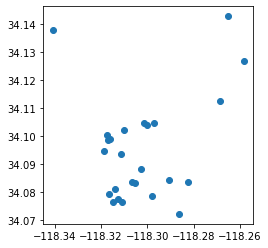

In [89]:
eho25_gdf.plot()

It plotted! Now checking that these 25 listings are within East Hollywood: 

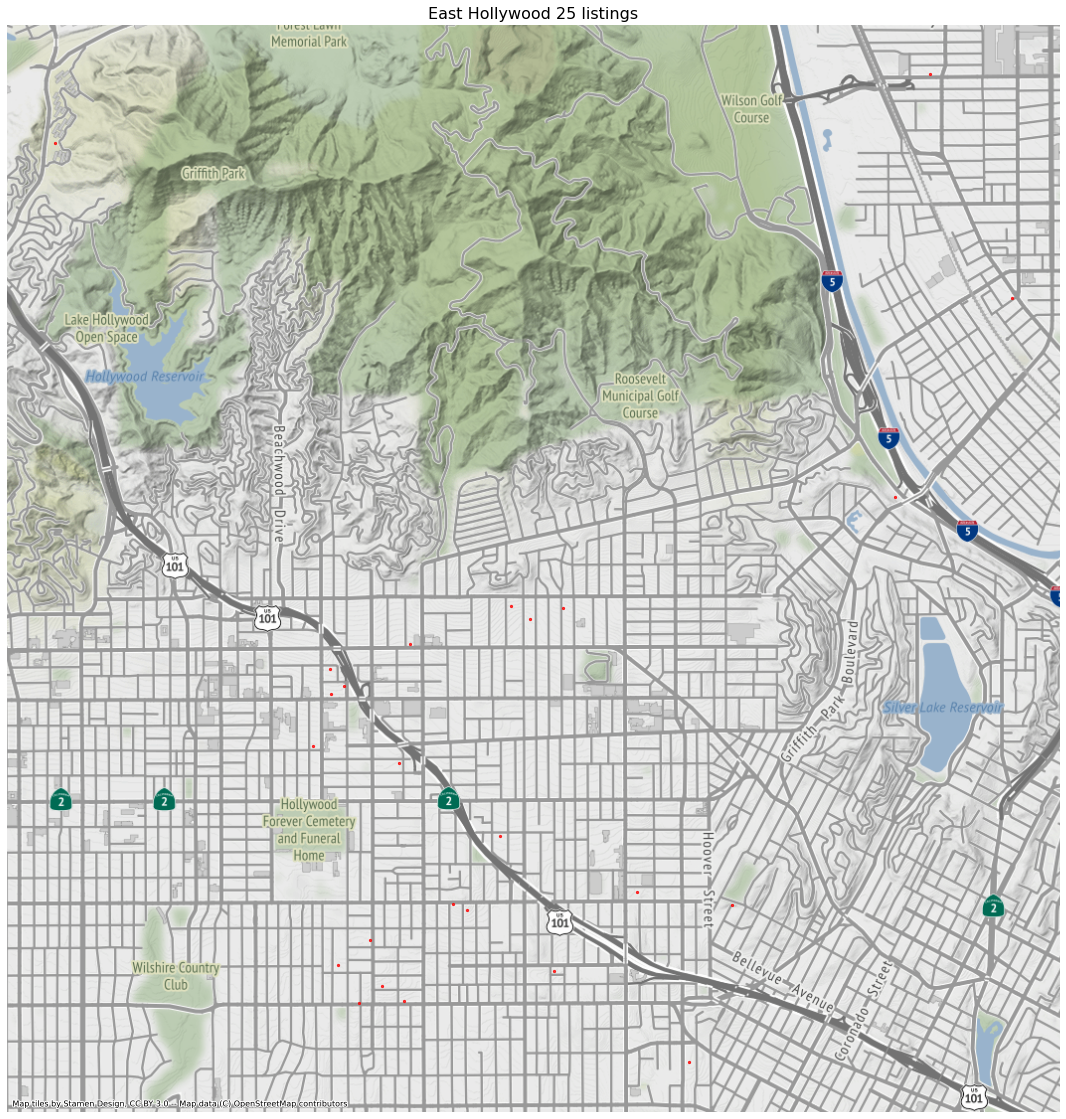

In [92]:
import matplotlib.pyplot as plt
import contextily as ctx

# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(20, 20))

# add the layer with ax=ax in the argument 
eho25_gdf.to_crs('EPSG:3857').plot(ax=ax, alpha=0.8, markersize=5, color = "red")

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('East Hollywood 25 listings',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

It looks like there's listings in this dataframe that are outside of East Hollywood, on the other side of the I-5 freeway. 

I haven't gotten to it yet, but I think I want to create a df holding the polygon geometries of each neighborhood, and use a spatial if statement to drop apt.com listings that don't intersect with the appropriate neighborhood. I'm planning to use this API: https://geohub.lacity.org/datasets/d6c55385a0e749519f238b77135eafac_0?geometry=-118.335%2C34.078%2C-118.252%2C34.103

The following code was run in a previous version of this notebook, with a getPosts() function that DID NOT SCRAPE the lat/lon or the unit_type/BR/rents columns. It took a really long time to run so I had saved csvs of all the dataframes -- but it seems I have to scrape again for the latlongs, and run all the visuals again after dropping listings that aren't in the right neighborhood. 

## **OLD CODE** Scrape 500 posts 

Now scraping 500 posts for each neighborhood:

In [ ]:
eho_500 = getPosts('East Hollywood', 500) 

In [16]:
hipa_500 = getPosts('Highland Park', 500)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


In [17]:
ktown_500 = getPosts('Koreatown', 500)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


In [18]:
bohe_500 = getPosts('Boyle Heights', 500)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475


In [66]:
# saving these to csvs so I don't have to scrape again: 
eho_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/eho_500_df.csv')
bohe_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/REALbohe_500_df.csv')
ktown_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/ktown_500_df.csv')
hipa_500.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/hipa_500_df.csv')

## Description NLP  

In [26]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\audre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\audre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Function 1. Create a long string of the Descriptions of each listing scraped 
Removing tags, lines, white spaces, tabs, punctuation with regex library

In [27]:
# function to turn a dataframe of posts into a long string with no punctuations 

def stringify_np(postdf, column):
    series = postdf[column].apply(str)
    list_ = series.tolist()
    string = str(list_)
    
    #remove tags 
    notags = re.sub(r"<[^>]*>", "", string)

    #remove new lines 
    nnline = re.sub(r"\\n", " ", notags)
    
    #remove white spaces and tabs (\t)
    words = re.sub(r"\s+", " ", nnline)
    
    #remove punctuation 
    words_np = re.sub(r"[^A-z\s]", "", words)
    
    return words_np
    

In [29]:
#test
stringify_np(hipa_500, "Description")

'[ About Moxie  Clover Welcome to Moxie  Clover located in what many call LA\\s greatest and hottest neighborhood Highland Park Set in an area known for its landmarks and peaceful atmosphere Moxie  Clover is the perfect apartment community for any lifestyle We offer newly renovated studios one and two bedrooms with inunit washerdryer fully equipped kitchens with brandnew appliances custom cabinetry hardwood style flooring and more We also happily welcome your furry ones to our petfriendly community Highland Park is home to many diverse restaurants adorable coffee shops bars movie theaters holistic healing recreational parks and malls Moxie  Clover is conveniently close to Pasadena Eagle Rock Downtown LA Silver Lake and Glendale We offer an irresistible combination of convenience and unrivaled quality that you can\\t find anywhere else Moxie  Clover is truly a great place to live and play Unique Features Amazon Hub Lockers Central Air Electronic Thermostat Energy Efficient Appliances EV

In [30]:
#save string of posts with no punctuation for each neighborhood

str_eho500 = stringify_np(eho_500, "Description")
str_hipa500 = stringify_np(hipa_500, "Description")
str_ktown500 = stringify_np(ktown_500, "Description")
str_bohe500 = stringify_np(bohe_500, "Description")


In [63]:
#save the string of 500 scraped posts for each neighborhood into a dataframe

descriptions = pd.DataFrame([str_eho500, str_bohe500, str_ktown500, str_hipa500])
descriptions.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/aptcom_descr_str.csv')

Now we're ready to find the word frequencies. 

### Function 2. Wordcounter with raw string 

In [40]:
# wordlists for each neighborhood's first 500 apt.com post descriptions 
wl500_eho = str_eho500.split()
wl500_hipa = str_hipa500.split()
wl500_ktown = str_ktown500.split()
wl500_bohe = str_bohe500.split()

In [41]:
def wordcounter(wordlist):
    counts = {} #dictionary to hold counts of each word
    for word in wordlist:
        lword = word.lower()
        if lword in counts: 
            counts[lword] += 1 
        else:
            counts[lword] = 1
    #dictionary --> dataframe        
    df = pd.DataFrame.from_dict(counts, orient = 'index', columns=['word_count']) #defines a new word_count column for the df
    df.sort_values('word_count', ascending=False, inplace=True)
    df.index.name = 'word'
    return df 

The top 50 frequency words for each neighborhood, without excluding stopwords: 

In [34]:
print("Raw Word Count for East Hollywood")
wordcounter(wl500_eho).head(50)

Raw Word Count for East Hollywood


word_count
word                  
and               3601
the               2856
in                1856
a                 1759
to                1649
with              1632
of                1472
is                 877
for                802
you                768
community          725
your               686
from               639
our                628
on                 619
about              598
hollywood          550
all                546
at                 533
features           503
homes              496
los                490
apartments         458
private            447
free               438
parking            438
new                434
this               428
home               406
appliances         391
are                366
shared             362
angeles            351
steel              348
stainless          348
select             342
apartment          340
room               339
unit               338
living             336
flooring           330
month              326
rent               312
including          309
by                 308
park               307
unique             307
bedroom            300
available          297
no                 297

In [35]:
print("Raw Word Count for Highland Park")

wordcounter(wl500_hipa).head(50)

Raw Word Count for Highland Park


word_count
word                    
and                 2490
the                 1899
to                  1366
a                   1195
of                   935
with                 866
in                   818
park                 707
new                  680
is                   604
about                516
unit                 514
highland             498
for                  438
los                  391
angeles              389
parking              323
ca                   311
features             307
apartment            299
units                298
pasadena             298
this                 275
apartments           268
appliances           266
unique               248
that                 248
kitchen              247
home                 244
at                   242
flooring             241
you                  241
on                   239
from                 234
offers               234
an                   230
all                  229
space                228
area                 224
community            223
laundry              222
remodeled            209
newly                209
bedroom              206
neighborhood         203
your                 194
or                   194
gated                190
located              181
st                   178

In [36]:
print("Raw Word Count for Koreatown")

wordcounter(wl500_ktown).head(50)

Raw Word Count for Koreatown


word_count
word                   
and                3302
the                2557
with               1867
in                 1596
to                 1420
a                  1184
of                 1067
available           960
amp                 718
for                 716
koreatown           631
on                  602
custom              560
about               553
our                 548
room                533
you                 529
apartments          527
is                  513
unique              512
features            485
flooring            476
your                443
pool                440
views               415
appliances          410
kitchen             403
units               392
are                 386
apartment           385
community           383
lounge              375
deck                370
designer            370
rooftop             360
fitness             360
wilshire            357
los                 352
angeles             350
parking             348
center              346
this                340
private             338
floor               338
countertops         334
more                331
new                 328
outdoor             316
balconies           312
stainless           306

In [37]:
print("Raw Word Count for Boyle Heights")

wordcounter(wl500_bohe).head(50)

Raw Word Count for Boyle Heights


word_count
word                  
and               2448
the               2310
to                1335
in                1024
of                1008
a                  940
with               683
is                 535
about              530
los                506
angeles            487
for                472
at                 440
this               439
you                418
new                366
are                363
apartments         348
la                 341
living             322
st                 319
your               316
downtown           313
ca                 313
district           306
unit               298
on                 292
arts               290
appliances         280
kitchen            279
amp                275
an                 272
lofts              271
home               260
private            258
unique             249
from               237
bathroom           231
or                 230
be                 223
features           217
building           213
located            212
as                 209
bedroom            206
apartment          201
our                188
all                185
e                  172
by                 170

### Function 3. Wordcounter Excluding Stopwords 

From the raw word frequencies, I picked out the uninteresting words to add to the stopwords list within this second word counting function.

In [48]:
def countWords_nostop(wordlist): 
    # original code: swords = [re.sub(r"[^A-z\s]", "", sword) for sword in stopwords.words('english')]
    swords = stopwords.words('english')
    swords.extend(('br', 'div', 'la', 'los', 'angeles', 'apartments', 'housing', 'apartment', 'month', 'lease', 'one', 'bedroom', 'homes', 'select', 'including', 'available', 'deposit','st','ca', 'amp', 'e', 'located', 'nd', 'ave'))
    ###add more stopwords to remove here^ 
    
    counts = {} # a dictionary to hold the counts
    for word in wordlist:
        # make lower case 
        lword = word.lower()
        
        # skip the stop words
        if lword in swords:
            continue
        
        # add to list of counts  
        elif lword in counts:
            counts[lword] +=1
        else:
            # doesn't exist in the dictionary
            counts[lword] = 1

    # convert the dictionary to a dataframe SOURCE: https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
    df = pd.DataFrame.from_dict(counts, orient='index', columns=['word_count'])

    # sort it by the word_count column
    df.sort_values('word_count', ascending=False, inplace=True)
    df.index.name = 'word'

    return df


In [49]:
print("Top 50 Most Frequently Used Words from East Hollywood's first 500 Apt.com Listing Descriptions")
eho_freq = countWords_nostop(wl500_eho)
eho_freq.head(50)

Top 50 Most Frequently Used Words from East Hollywood's first 500 Apt.com Listing Descriptions


word_count
word                   
community           725
hollywood           550
features            503
private             447
parking             438
free                438
new                 434
home                406
appliances          391
shared              362
stainless           348
steel               348
room                339
unit                338
living              336
flooring            330
rent                312
park                307
unique              307
access              296
furnished           286
village             272
cabinetry           266
fitness             266
common              266
onsite              261
modern              252
storage             251
deck                249
amenities           247
rooftop             247
area                240
kitchens            228
studio              218
live                214
spaces              212
views               212
call                212
central             212
enjoy               211
lounge              210
luxury              209
kitchen             206
laundry             202
large               201
included            200
beverly             195
larchmont           194
fixtures            193
countertops         192

In [50]:
print("Top 50 Most Frequently Used Words from Boyle Heights' first 500 Apt.com Listing Descriptions")
bohe_freq = countWords_nostop(wl500_bohe)
bohe_freq.head(50)

Top 50 Most Frequently Used Words from Boyle Heights' first 500 Apt.com Listing Descriptions


word_count
word                   
new                 366
living              322
downtown            313
district            306
unit                298
arts                290
appliances          280
kitchen             279
lofts               271
home                260
private             258
unique              249
bathroom            231
features            217
building            213
property            167
furnished           165
stainless           165
steel               165
access              162
community           160
welcome             159
restaurants         156
luxury              150
street              147
flooring            143
full                141
floor               139
area                132
dtla                127
location            126
laundry             122
floors              120
aliso               120
art                 119
tour                118
center              116
renovated           115
virtual             113
dryer               113
washer              113
fully               113
amenities           112
based               111
easy                110
heart               109
style               108
large               107
garage              107
spacious            107

In [51]:
print("Top 50 Most Frequently Used Words from Koreatown's first 500 Apt.com Listing Descriptions")
ktown_freq = countWords_nostop(wl500_ktown)
ktown_freq.head(50)

Top 50 Most Frequently Used Words from Koreatown's first 500 Apt.com Listing Descriptions


word_count
word                   
koreatown           631
custom              560
room                533
unique              512
features            485
flooring            476
pool                440
views               415
appliances          410
kitchen             403
units               392
community           383
lounge              375
designer            370
deck                370
rooftop             360
fitness             360
wilshire            357
parking             348
center              346
private             338
floor               338
countertops         334
new                 328
outdoor             316
balconies           312
stainless           306
studio              295
cabinetry           289
steel               287
amenities           277
closets             266
living              263
plans               262
quartz              256
area                236
home                233
modern              232
hollywood           230
fire                228
two                 227
closet              226
resident            220
park                219
fixtures            217
kitchens            205
brand               205
access              200
large               199
space               197

In [52]:
print("Top 50 Most Frequently Used Words from Highland Park's first 500 Apt.com Listing Descriptions")
hipa_freq = countWords_nostop(wl500_hipa)
hipa_freq.head(50)

Top 50 Most Frequently Used Words from Highland Park's first 500 Apt.com Listing Descriptions


word_count
word                    
park                 707
new                  680
unit                 514
highland             498
parking              323
features             307
pasadena             298
units                298
appliances           266
unique               248
kitchen              247
home                 244
flooring             241
offers               234
space                228
area                 224
community            223
laundry              222
newly                209
remodeled            209
neighborhood         203
gated                190
access               176
outdoor              173
downtown             173
spacious             171
ac                   171
renovated            171
free                 167
floor                156
offer                154
private              154
room                 152
steel                152
pool                 152
away                 152
stainless            152
countertops          146
bathroom             146
residents            137
call                 135
heart                133
includes             133
central              133
air                  133
floors               133
move                 126
living               120
avenue               118
figueroa             117

NOTE: THIS ANALYSIS DID NOT REMOVE LISTINGS THAT FALL OUTSIDE OF NEIGHBORHOOD BOUNDARIES 

The top frequency word for East Hollywood is **"community"**, for Boyle Heights **"new"**, for Koreatown **"custom"**, and for Highland Park it's **"new"** as well. 

**"parking"** was pretty high up on the list for East Hollywood and Highland Park, a bit further down for Koreatown, and didn't make the top 50 for Boyle Heights. 

Also interesting was how frequently nearby neighborhoods like **"downtown"** and **"arts district"** and **"figueroa"** and **"larchmont"** appeared in the listing descriptions. 

# Amenities NLP 

As noted earlier, apartments.com provides three categories of amenities. "Unique Amenities" seem to be filled in freeform by the listing agent, while "Apartment Features" annd "Community Amenities" are more standardized. 

In [64]:
bohe_500.head()

Listing  \
0                           The Garey Building   
1                             Aliso Apartments   
2                                    Amp Lofts   
3  The Newberry Lofts / Artist Loft Apartments   
4                               Artisan on 2nd   

                                     Address  \
0        905 E 2nd St, Los Angeles, CA 90012   
1        950 E 3rd St, Los Angeles, CA 90013   
2  695 S Santa Fe Ave, Los Angeles, CA 90021   
3        900 E 1st St, Los Angeles, CA 90012   
4        601 E 2nd St, Los Angeles, CA 90012   

                                         Description           Price  \
0  [\n, [About The Garey Building], \n, [TOUR YOU...  $1,849 - 6,370   
1  [\n, [About Aliso Apartments], \n, [GATHER AND...  $1,834 - 5,285   
2  [\n, [About Amp Lofts], \n, [In-person tours a...  $1,800 - 5,063   
3  [\n, [About The Newberry Lofts / Artist Loft A...  $2,450 - 3,550   
4  [\n, [About Artisan on 2nd], \n, [Artisan on 2...  $2,919 - 3,183   

        Unit Type                                Unique Amenities  \
0  Studio - 2 Bed  \nDistinctive Wood-Style Flooring Throughout\n   
1  Studio - 2 Bed                     \n2-inch faux wood blinds\n   
2  Studio - 2 Bed                      \n#Gallery (Art Gallery)\n   
3          Studio                             \nCement Flooring\n   
4         1-2 Bed                           \nControlled Access\n   

           Apartment Features  \
0  High Speed Internet Access   
1  High Speed Internet Access   
2            Air Conditioning   
3  High Speed Internet Access   
4            Air Conditioning   

                                 Community Amenities Property Manager  \
0                                               None             \n\n   
1                                               None             \n\n   
2  \n\nMaintenance on site\n\n\nConcierge\n\n\nOn...             \n\n   
3  \n\nLaundry Facilities\n\n\nControlled Access\...             None   
4  \n\nLaundry Facilities\n\n\nMaintenance on sit...             \n\n   

                                                 URL  
0  https://www.apartments.com/the-garey-building-...  
1  https://www.apartments.com/aliso-apartments-lo...  
2  https://www.apartments.com/amp-lofts-los-angel...  
3  https://www.apartments.com/the-newberry-lofts-...  
4  https://www.apartments.com/artisan-on-2nd-los-...

### Save Dataframes

I was paranoid about losing the scraping so I saved the amenities into separate dataframes/csvs too: 

#### East Hollywood Amenities

In [128]:
#East Hollywood Amenities 
ua_eho_list = eho_500['Unique Amenities']
ua_eho_df = pd.DataFrame(ua_eho_list)

af_eho_list = eho_500['Apartment Features']
af_eho_df = pd.DataFrame(af_eho_list)

ca_eho_list = eho_500['Community Amenities']
ca_eho_df = pd.DataFrame(ca_eho_list)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [130]:
eho_amenities = pd.DataFrame()
eho_amenities['Unique Amenities'] = eho_500['Unique Amenities']
eho_amenities['Apartment Features'] =  eho_500['Apartment Features']
eho_amenities['Community Amenities'] = eho_500['Community Amenities']
eho_amenities

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unique Amenities          Apartment Features  \
0                                  \nBarbecues\n  High Speed Internet Access   
1                               \n2 Courtyards\n  High Speed Internet Access   
2    \n20 min from Downtown LA Financial Dist.\n            Air Conditioning   
3                                           None            Air Conditioning   
4                                           None            Air Conditioning   
..                                           ...                         ...   
495     \nAdditional Storage Available On-Site\n  High Speed Internet Access   
496                         \nmodern cabinetry\n  Stainless Steel Appliances   
497            \n24-Hour Emergency Maintenance\n            Air Conditioning   
498                  \nCaesarstone Countertops\n  High Speed Internet Access   
499                                         None                 Cable Ready   

                                   Community Amenities  
0    \n\nControlled Access\n\n\nOnline Services\n\n...  
1                                                 None  
2    \n\nProperty Manager on Site\n\n\nFurnished Un...  
3    \n\nControlled Access\n\n\nRecycling\n\n\nOnli...  
4    \n\nControlled Access\n\n\nSecurity System\n\n...  
..                                                 ...  
495                                               None  
496  \n\nLaundry Facilities\n\n\nControlled Access\...  
497  \n\nPackage Service\n\n\nWi-Fi at Pool and Clu...  
498  \n\nLaundry Facilities\n\n\nControlled Access\...  
499  \n\nLaundry Facilities\n\n\nControlled Access\...  

[500 rows x 3 columns]

In [131]:
eho_amenities['Unique Amenities'].loc[0]

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\nBarbecues\n'

#### Boyle Heights Amenities

In [132]:
bohe_amenities = pd.DataFrame()
bohe_amenities['Unique Amenities'] = bohe_500['Unique Amenities']
bohe_amenities['Apartment Features'] =  bohe_500['Apartment Features']
bohe_amenities['Community Amenities'] = bohe_500['Community Amenities']
bohe_amenities

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unique Amenities  \
0    \nDistinctive Wood-Style Flooring Throughout\n   
1                       \n2-inch faux wood blinds\n   
2                        \n#Gallery (Art Gallery)\n   
3                               \nCement Flooring\n   
4                             \nControlled Access\n   
..                                              ...   
470                                            None   
471                                            None   
472                                            None   
473                                            None   
474                                            None   

             Apartment Features  \
0    High Speed Internet Access   
1    High Speed Internet Access   
2              Air Conditioning   
3    High Speed Internet Access   
4              Air Conditioning   
..                          ...   
470                        None   
471                        None   
472                        None   
473                        None   
474                        None   

                                   Community Amenities  
0                                                 None  
1                                                 None  
2    \n\nMaintenance on site\n\n\nConcierge\n\n\nOn...  
3    \n\nLaundry Facilities\n\n\nControlled Access\...  
4    \n\nLaundry Facilities\n\n\nMaintenance on sit...  
..                                                 ...  
470  \n\nWasher/Dryer - In Unit\n\n\nAir Conditioni...  
471  \n\nWi-Fi\n\n\nAir Conditioning\n\n\nSmoke Fre...  
472                                               None  
473  \n\nWasher/Dryer - In Unit\n\n\nAir Conditioni...  
474  \n\nWasher/Dryer - In Unit\n\n\nAir Conditioni...  

[475 rows x 3 columns]

#### Koreatown Amenities

In [133]:
ktown_amenities = pd.DataFrame()
ktown_amenities['Unique Amenities'] = ktown_500['Unique Amenities']
ktown_amenities['Apartment Features'] =  ktown_500['Apartment Features']
ktown_amenities['Community Amenities'] = ktown_500['Community Amenities']
ktown_amenities

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unique Amenities          Apartment Features  \
0                           \nCOMMERCIAL SPACE\n  High Speed Internet Access   
1                                  \nBike Park\n  High Speed Internet Access   
2                               \n2 Courtyards\n  High Speed Internet Access   
3        \n2 Sparkling Pools and Relaxing Spas\n                 Cable Ready   
4                            \nCommunity Wi-Fi\n            Air Conditioning   
..                                           ...                         ...   
494                            \n9-ft ceilings\n                Washer/Dryer   
495    \n24 Hour Emergency Maintenance Service\n  High Speed Internet Access   
496     \nBalconies With Swing Doors Available\n                       Wi-Fi   
497     \nBalconies With Swing Doors Available\n  High Speed Internet Access   
498  \nCommunity Laundry Room For Larger Loads\n  High Speed Internet Access   

                                   Community Amenities  
0                                                 None  
1    \n\nWi-Fi at Pool and Clubhouse\n\n\nControlle...  
2                                                 None  
3                                                 None  
4    \n\nWi-Fi at Pool and Clubhouse\n\n\nControlle...  
..                                                 ...  
494  \n\nLounge\n\n\nFitness Center\n\n\nPool\n\n\n...  
495  \n\nPackage Service\n\n\nMaintenance on site\n...  
496  \n\nElevator\n\n\nClubhouse\n\n\nLounge\n\n\nF...  
497  \n\nCommunity-Wide WiFi\n\n\nWi-Fi at Pool and...  
498  \n\nWi-Fi at Pool and Clubhouse\n\n\nLaundry F...  

[499 rows x 3 columns]

#### Highland Park Amenities

In [134]:
hipa_amenities = pd.DataFrame()
hipa_amenities['Unique Amenities'] = hipa_500['Unique Amenities']
hipa_amenities['Apartment Features'] =  hipa_500['Apartment Features']
hipa_amenities['Community Amenities'] = hipa_500['Community Amenities']
hipa_amenities

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unique Amenities          Apartment Features  \
0     \nAmazon Hub Lockers\n  High Speed Internet Access   
1                       None                        None   
2    \nAppliances Included\n            Air Conditioning   
3       \nBocce Ball Court\n                Washer/Dryer   
4                       None  High Speed Internet Access   
..                       ...                         ...   
495                     None                        None   
496                     None                        None   
497                     None                        None   
498                     None                        None   
499                     None                        None   

                                   Community Amenities  
0    \n\nPackage Service\n\n\nLaundry Facilities\n\...  
1    \n\nLaundry Facilities\n\n\nControlled Access\...  
2    \n\nControlled Access\n\n\nProperty Manager on...  
3    \n\nProperty Manager on Site\n\n\nOnline Servi...  
4                  \n\nLaundry Facilities\n\n\nSpa\n\n  
..                                                 ...  
495  \n\nAir Conditioning\n\n\nHeating\n\n\nSmoke F...  
496  \n\nWasher/Dryer - In Unit\n\n\nAir Conditioni...  
497  \n\nAir Conditioning\n\n\nMicrowave\n\n\nLaund...  
498  \n\nWasher/Dryer - In Unit\n\n\nAir Conditioni...  
499  \n\nSmoke Free\n\n\nGranite Countertops\n\n\nK...  

[500 rows x 3 columns]

In [140]:
#amenities dataframes - in another notebook, import these amenities dfs and stringify_np() function to do wordcounter.
eho_amenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/eho_amenities.csv') 
bohe_amenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/bohe_amenities.csv') 
ktown_amenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/ktown_amenities.csv') 
hipa_amenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/hipa_amenities.csv') 

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Groupby Amenities

It would be really helpful for my real estate classes to be able to convert this info into a table with a column for every amenity, with the rows filled in as booleans for each listing. I'm not sure if figuring out how to do this in python would be easier than just manipulating the spreadsheets though?

## Word Counter on Amenities 

### Convert the amenity columns into long strings

In [118]:
ua_eho = stringify_np(eho_500, "Unique Amenities")
ua_hipa = stringify_np(hipa_500, "Unique Amenities")
ua_ktown = stringify_np(ktown_500, "Unique Amenities")
ua_bohe = stringify_np(bohe_500, "Unique Amenities")

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
af_eho = stringify_np(eho_500, "Apartment Features")
af_hipa = stringify_np(hipa_500, "Apartment Features")
af_ktown = stringify_np(ktown_500, "Apartment Features")
af_bohe = stringify_np(bohe_500, "Apartment Features")

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
ca_eho = stringify_np(eho_500, "Community Amenities")
ca_hipa = stringify_np(hipa_500, "Community Amenities")
ca_ktown = stringify_np(ktown_500, "Community Amenities")
ca_bohe = stringify_np(bohe_500, "Community Amenities")

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### countWords_nostop() function on amenities

In [135]:
# wordlists for each neighborhood's first 500 apt.com post descriptions 

##unique amenities
wlua_eho = ua_eho.split()
wlua_hipa = ua_hipa.split()
wlua_ktown = ua_ktown.split()
wlua_bohe = ua_bohe.split()


##apartment features
wlaf_eho = af_eho.split()
wlaf_hipa = af_hipa.split()
wlaf_ktown = af_ktown.split()
wlaf_bohe = af_bohe.split()


##community amenities 
wlca_eho = ca_eho.split()
wlca_hipa = ca_hipa.split()
wlca_ktown = ca_ktown.split()
wlca_bohe = ca_bohe.split()

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Unique Amenities

In [139]:
print("Unique Amenities Frequencies - East Hollywood")
eho_uniqueamenities = countWords_nostop(wlua_eho)
eho_uniqueamenities

Unique Amenities Frequencies - East Hollywood


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                    
none                 214
courtyards            38
racks                 38
bike                  38
ceiling               19
storage               19
space                 19
artist                19
studio                19
additional            19
onsite                19
heights               19
modern                19
cabinetry             19
hour                  19
emergency             19
maintenance           19
balconypatio          19
balconies             19
barbecues             19
countertops           19
lounge                19
coffee                19
pits                  19
fire                  19
soon                  19
coming                19
dist                  19
financial             19
downtown              19
min                   19
caesarstone           19
[                      1
none]                  1

**"Courtyards"** and **"bike racks"** seem to be the most popular amenities for East Hollywood listings. 

In [141]:
print("Unique Amenities Frequencies - Boyle Heights")
bohe_uniqueamenities = countWords_nostop(wlua_bohe)
bohe_uniqueamenities

Unique Amenities Frequencies - Boyle Heights


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                   
none                326
flooring             33
gallery              26
hour                 18
courtesy             18
street               18
across               18
park                 18
nice                 18
use                  18
commercial           18
patrol               18
access               18
controlled           18
blinds               18
wood                 18
faux                 18
inch                 18
cement               17
distinctive          16
throughout           16
woodstyle            16
art                  13
included             12
utilities            12
except               12
cable                12
[                     1
none]                 1

Some kind of fancy **"flooring"** and **"gallery"** were highest frequency in Boyle Heights.

In [147]:
print("Unique Amenities Frequencies - Koreatown")
ktown_uniqueamenities = countWords_nostop(wlua_ktown)
ktown_uniqueamenities.tail(25)

Unique Amenities Frequencies - Koreatown


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                 
rooftop            19
barbecues          19
spa                19
burner             18
range              18
skylobby           18
gas                18
bbq                17
ft                 17
ceilings           17
pup                16
brand              16
new                16
loads              14
laundry            14
room               14
larger             14
sunsets            11
nightly            11
spots               8
free                8
parking             8
sun                 5
[                   1
]                   1

In Koreatown the highest frequency amenities were **"rooftop"**, **"barbecues"**, and **"spa"**. As a Ktown resident this seems to hit the mark.

In [148]:
print("Unique Amenities Frequencies - Highland Park")
hipa_uniqueamenities = countWords_nostop(wlua_hipa)
hipa_uniqueamenities

Unique Amenities Frequencies - Highland Park


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                   
none                309
hub                  38
appliances           38
amazon               38
free                 19
move                 19
efficient            19
space                19
outdoor              19
ac                   19
centralized          19
laundry              19
remodeled            19
pool                 19
courtyards           19
rent                 19
steel                19
management           19
package              19
court                19
ball                 19
bocce                19
included             19
lockers              19
stainless            19
[                     1
none]                 1

And lastly, Highland Park listings have a lot of **"amazon hubs"** and **"appliances"**.

#### Apartment Features

In [151]:
print("Apartment Features Frequencies - East Hollywood")
eho_aptfea = countWords_nostop(wlaf_eho)
eho_aptfea

Apartment Features Frequencies - East Hollywood


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                    
internet             188
access               188
speed                188
high                 187
none                 101
air                   97
conditioning          97
washerdryer           38
free                  19
appliances            19
steel                 19
stainless             19
fans                  19
smoke                 19
ceiling               19
cable                 19
ready                 18
[high                  1
ready]                 1

In [152]:
print("Apartment Features Frequencies - Boyle Heights")
bohe_aptfea = countWords_nostop(wlaf_bohe)
bohe_aptfea

Apartment Features Frequencies - Boyle Heights


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                    
none                 326
speed                 87
internet              87
access                87
high                  86
air                   31
conditioning          31
washerdryer           18
wifi                  12
[high                  1
none]                  1

In [153]:
print("Apartment Features Frequencies - Koreatown")
ktown_aptfea = countWords_nostop(wlaf_ktown)
ktown_aptfea

Apartment Features Frequencies - Koreatown


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                    
speed                234
internet             234
access               233
high                 233
air                   71
conditioning          71
none                  68
washerdryer           35
heating               34
cable                 19
ready                 19
kitchen               19
wifi                  19
[high                  1
unit                   1
access]                1

In [154]:
print("Apartment Features Frequencies - Highland Park")
hipa_aptfea = countWords_nostop(wlaf_hipa)
hipa_aptfea

Apartment Features Frequencies - Highland Park


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                    
none                 252
speed                114
internet             114
access               114
high                 113
air                   76
conditioning          76
washerdryer           19
remodeled             19
laundry               19
centralized           19
ac                    19
wifi                  19
[high                  1
none]                  1

For apartment features, **"high speed internet access"** and **"air conditioning"** were across the board the highest frequency amenities.

#### Community Amenities 

In [163]:
print("Community Amenities Frequencies - East Hollywood")
eho_comm = countWords_nostop(wlca_eho)
eho_comm.head(25)

Community Amenities Frequencies - East Hollywood


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                      
laundry                221
access                 196
controlled             196
service                190
site                   190
facilities             183
none                   173
center                 171
gated                  146
elevator               137
recycling              133
pool                   116
furnished              116
units                  115
lounge                 114
fitness                114
transportation         114
public                 114
manager                114
property               114
storage                 96
wifi                    95
services                95
online                  95
spa                     77

**"Laundry"** and **"controlled access"** seems to be key community amenities advertised in East Hollywood.

In [164]:
print("Community Amenities Frequencies - Boyle Heights")
bohe_comm = countWords_nostop(wlca_bohe)
bohe_comm.head(25)

Community Amenities Frequencies - Boyle Heights


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                    
air                  170
conditioning         170
washerdryer          161
dishwasher           153
appliances           136
stainless            136
steel                136
furnished            134
laundry              132
facilities           132
kitchen              131
refrigerator         131
none                 129
free                 120
smoke                120
unit                 117
heating              116
fitness              115
center               115
pool                  97
site                  96
gated                 95
floors                94
hardwood              94
elevator              84

...whereas in Boyle Heights, appliances such as AC, washer dryers, dishwashers are most highlighted.

In [ ]:
print("Community Amenities Frequencies - Koreatown")
ktown_comm = countWords_nostop(wlca_ktown)
ktown_comm.head(25)

In Ktown, community amenities like **"pool"**, **"clubhouse"**, **"fitness center"** seem to target the young professional class? 

In [166]:
print("Community Amenities Frequencies - Highland Park")
hipa_comm = countWords_nostop(wlca_hipa)
hipa_comm.head(25)

Community Amenities Frequencies - Highland Park


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


word_count
word                    
laundry              306
facilities           306
gated                231
site                 209
access               178
controlled           171
property             171
manager              171
conditioning         158
air                  158
pool                 133
free                 123
smoke                123
kitchen               98
washerdryer           97
courtyard             96
refrigerator          95
granite               89
countertops           89
unit                  78
storage               78
fenced                77
lot                   77
tubshower             76
oven                  76

Highland Park loves its **"laundry"** and **"gated"** ness. 

In [168]:
eho_uniqueamenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/eho_ua_freq.csv') 
bohe_uniqueamenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/bohe_ua_freq.csv') 
ktown_uniqueamenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/ktown_ua_freq.csv') 
hipa_uniqueamenities.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/hipa_ua_freq.csv') 

eho_aptfea.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/eho_af_freq.csv') 
bohe_aptfea.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/bohe_af_freq.csv') 
ktown_aptfea.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/ktown_af_freq.csv') 
hipa_aptfea.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/hipa_af_freq.csv') 

eho_comm.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/eho_ca_freq.csv') 
bohe_comm.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/bohe_ca_freq.csv') 
ktown_comm.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/ktown_ca_freq.csv') 
hipa_comm.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/hipa_ca_freq.csv') 


C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Gentrification Code Words

I added the following words as gentrification code words: 
* Amenities offered onsite ('private', 'security', 'lounge', luxury', 'gated', 'modern', 'prime')
* Neighborhood characteristics ('central', 'downtown', 'walking', 'accessible', 'charming', 'quirky', 'unique', 'quaint', 'coming', 'authentic', 'restaurants', 'culture', 'cultural', 'foodies', 'diverse', 'character', 'vibe', 'hip', 'dense', 'cool,' 'funky', 'landmark', 'historic')
* Yuppie characteristics ('vegan', 'gluten', 'art', 'bars', 'beer', 'stadium', 'preserved', 'outdoors')
* Who is the target audience? ('affordable', 'upscale', 'leisure', 'budget') 


Apartments.com has neighborhood descriptions, so I picked some interesting words to include in our gentrification code word list.

East Hollwood
* Although smaller than its better-known neighbor to the west, East Hollywood is a **central**ly located neighborhood in Los Angeles. East Hollywood is **accessible** to various freeways and many other popular neighborhoods, so commuters are set. This neighborhood boasts **lower rent costs** than its neighbors, a **diverse** community, and **unique** restaurants. Los Angeles City College, Barnsdall Art Park, and three large hospitals are all located in the East Hollywood area. This community sits just two miles from **Downtown** Los Angeles, making it popular for those interested in staying close to the city. With a **dense** population and a **hip vibe**, East Hollywood is the place to be.

Boyle Heights
* Southeast Los Angeles is directly south of the Fashion District and east of the University of Southern California (USC). This large neighborhood is minutes from downtown Los Angeles, Hollywood, and Beverly Hills. Downtown LA lies just on the other side of the 110 Freeway, a mere two miles away. This **densely-populated**, **diverse** neighborhood features everything LA, from **food** trucks and corner markets to wide sidewalks and residential areas filled with bungalows, ranch, and Spanish Colonial **architecture**. Southeast LA features palm trees and mountain views, tampered with gritty undertones to give it a **cool, funky vibe**. In this neighborhood, tattoo parlors sit next to Asian markets, and in the alleyway a colorful mural adorns the side of the building. One area **landmark**, the **historic** Los Angeles Memorial Coliseum, sits on the other side of the 110 Freeway and played host to the 1932 and 1984 summer Olympics. Currently home to the USC Trojans, the **stadium** has also counted the Los Angeles Raiders and Dodgers as residents at one time or the other in their storied histories.

Koreatown
* As the name suggests, the atmosphere in Koreatown is heavily influenced by Korean **culture**, and it is a favorite **destination** among **foodies** city-wide for its endless selection of **authentic** Korean restaurants. But the community has a much more **diverse** character than that: The broad range of **cultural** influences is exemplified in **landmarks** like the synagogue/contemporary **art gallery** of the Wilshire Boulevard Temple, the Latin fusion cuisine of Roy Choi’s **restaurants**, and the popular German/Korean/Hawaiian tinged gastropub, Biergarten. As one of the most popular sections of LA during Hollywood’s golden age, many **historic** buildings, **bars**, and **restaurants** have been **preserved** or **restored** to transport patrons to another time—in fact, the interiors of several local eateries were used as locations for the 1960s-set TV series, “Mad Men.”

Highland Park
* A large sector of the city, Northeast Los Angeles encompasses neighborhoods like Echo Park and Highland Park. This expansive LA area offers rentals for every type of renter and every **budget**. Abundant apartments, houses, condos, and townhomes can be found in Northeast Los Angeles, ranging from **affordable** to **upscale**. Residents of this area can enjoy the great **outdoors** at locales like Ernest E. Debs Regional **Park**, Hermon Park, Rio De Los Angeles State Park, and Elysian Park. Although Northeast LA offers an **escape** from big-city living, residents can easily travel into **downtown** for work or **leisure**. **Amenities** and **attractions** like Dodger Stadium, Los Angeles State Historic Park, and Chinatown are all within reach of this sprawling district.





In [53]:
g_codes = ['private', 'amenities','lounge', 'luxury','luxurious','gated','unique','modern','prime','bars','restaurants', 'safe','walk','walking','walkable', 'security', 'vegan','gluten', 'private', 'security', 'lounge', 'luxury', 'gated', 'modern', 'prime', 'central', 'downtown', 'walking', 'accessible', 'charming', 'quirky', 'unique', 'quaint', 'coming', 'authentic', 'restaurants', 'culture', 'cultural', 'foodies', 'diverse', 'character', 'vibe', 'hip', 'dense', 'cool,' 'funky', 'landmark', 'historic', 'vegan', 'gluten', 'art', 'bars', 'beer', 'stadium', 'preserved', 'outdoors', 'affordable', 'upscale', 'leisure', 'budget', 'vegan', 'gluten', 'art', 'bars', 'beer', 'stadium', 'preserved', 'outdoors']

In [54]:
print("Frequency of Selected Keywords in East Hollywood")
eho_freq = eho_freq.reset_index()
eho_g = eho_freq[eho_freq['word'].isin(g_codes)]
eho_g['count_per_10posts'] = eho_g['word_count']/len(eho_500)*10 #normalize by number of posts scraped 
eho_g

Frequency of Selected Keywords in East Hollywood


<ipython-input-54-68c7d2525643>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eho_g['count_per_10posts'] = eho_g['word_count']/len(eho_500)*10 #normalize by number of posts scraped


word  word_count  count_per_10posts
3         private         447               8.94
18         unique         307               6.14
26         modern         252               5.04
29      amenities         247               4.94
38        central         212               4.24
40         lounge         210               4.20
41         luxury         209               4.18
53       downtown         176               3.52
103      security         120               2.40
130          walk         102               2.04
164        coming          95               1.90
199       walking          78               1.56
216          bars          77               1.54
257         prime          61               1.22
325           art          57               1.14
372         gated          44               0.88
466     authentic          38               0.76
612   restaurants          25               0.50
663       upscale          21               0.42
737     luxurious          19               0.38
756          safe          19               0.38
820       foodies          19               0.38
896      outdoors          19               0.38
907    accessible          19               0.38
917       diverse          19               0.38
1177     walkable          19               0.38
1370     charming           1               0.02
1439    character           1               0.02
1484          hip           1               0.02
1498     historic           1               0.02

Of the hand picked gentrification code words, **"private"** has the highest frequency for East Hollywood. 

IMPORTANT NOTE: When I ran the wordcounter and bar graph visualization on these gentrification code words last time, I accidentally ran the East Hollywood code four times. I changed the code but didn't have time to run it to derive insights for Boyle Heights, Koreatown, and Highland Park. 

In [ ]:
print("Frequency of Selected Keywords in Boyle Heights")
bohe_freq = bohe_freq.reset_index()
bohe_g = bohe_freq[bohe_freq['word'].isin(g_codes)]
bohe_g['count_per_10posts'] = bohe_g['word_count']/len(bohe_500)*10 #normalize by number of posts scraped 
bohe_g

In [ ]:
print("Frequency of Selected Keywords in Koreatown")
ktown_freq = ktown_freq.reset_index()
ktown_g = ktown_freq[ktown_freq['word'].isin(g_codes)]
ktown_g['count_per_10posts'] = ktown_g['word_count']/len(ktown_500)*10 #normalize by number of posts scraped 
ktown_g

In [ ]:
print("Frequency of Selected Keywords in Highland Park")
hipa_freq = hipa_freq.reset_index()
hipa_g = hipa_freq[eho_freq['word'].isin(g_codes)]
hipa_g['count_per_10posts'] = hipa_g['word_count']/len(hipa_500)*10 #normalize by number of posts scraped 
hipa_g

# Visuals 
## 1. Bar graph of gentrification code words 

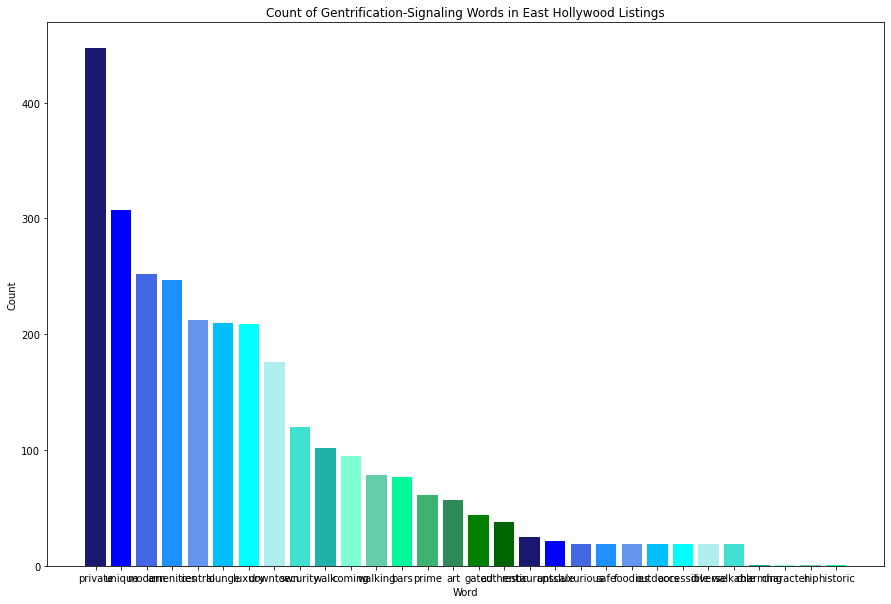

In [61]:
#bar chart
import matplotlib.pyplot as plt  
plt.figure(figsize=(15,10))
plt.bar(eho_g['word'], eho_g['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Count of Gentrification-Signaling Words in East Hollywood Listings")
plt.show()
#text = mylines_words



Is there a way to add a legend of the list of gentrification code words on the side instead of on the x axis?

In [ ]:
#bar chart
import matplotlib.pyplot as plt  
plt.figure(figsize=(15,10))
plt.bar(bohe_g['word'], bohe_g['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Count of Gentrification-Signaling Words in Boyle Heights Listings")
plt.show()
#text = mylines_words



In [ ]:
#bar chart
import matplotlib.pyplot as plt  
plt.figure(figsize=(15,10))
plt.bar(ktown_g['word'], ktown_g['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Count of Gentrification-Signaling Words in Koreatown Listings")
plt.show()
#text = mylines_words



In [ ]:
#bar chart
import matplotlib.pyplot as plt  
plt.figure(figsize=(15,10))
plt.bar(hipa_g['word'], hipa_g['word_count'], color=['midnightblue', 'blue','royalblue','dodgerblue','cornflowerblue','deepskyblue','cyan','paleturquoise', 'turquoise','lightseagreen','aquamarine','mediumaquamarine','mediumspringgreen','mediumseagreen','seagreen','green','darkgreen'])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Count of Gentrification-Signaling Words in Highland Park Listings")
plt.show()
#text = mylines_words



## 2. Word cloud of descriptions (Just for fun)

In [74]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#conda install wordcloud-c conda-forge

In [75]:
swords = stopwords.words('english')
swords.extend(('br', 'div', 'la', 'los', 'angeles', 'apartments', 'housing', 'apartment', 'month', 'lease', 'one', 'bedroom', 'homes', 'select', 'including', 'available', 'deposit','st','ca', 'amp', 'e', 'located', 'nd', 'ave'))

In [79]:
# how do we drop stopwords from a list? 
#how to define a function using lamda to strip certain words from the string?? 
string_eho500_nosword = [word for word in word_tokenize(str_eho500.lower()) if word not in swords]
string_eho500_nosword = str(string_eho500_nosword)
string_eho500_nosword = re.sub(r"[^A-z\s]", "", string_eho500_nosword)
string_eho500_nosword = re.sub(r"\s+", " ", string_eho500_nosword)
string_eho500_nosword

'[[ lido lido community brand new modern large two three bedrooms stylish top quality finishes designer kitchens custom cabinetry w self closing doors drawers high end appliances refrigerators dishwashers gas stoves electric ovens microwaves dishwashers washerdryers oversized sinks wood vinyl floors throughout stylish bathrooms italian tiles oversized bathtubs balconies building amenities include fitness center game room bar large flatscreen televisions ping pong table foosball table business center rooftop deck incredible city mountain views outdoor television built barbecue bars firepits sun tanning decks lounge chairs tables really cool place hang gated parking gated entry units come parking spaces dont charge extra parking grand opening august pre leasing unique features barbecues built barbecue bars chaise lounges sun bathing custom cabinetry w self closing doors designer kitchen designer kitchens designer kitchens custom cabinetry electric ovens entertainment lounge outdoor tv fi

East Hollywood Word Cloud


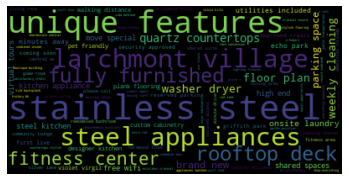

In [80]:
print("East Hollywood Word Cloud") 
wordcloud = WordCloud().generate(string_eho500_nosword)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [85]:
string_bohe500_nosword = [word for word in word_tokenize(str_bohe500.lower()) if word not in swords]
string_bohe500_nosword = str(string_bohe500_nosword)
string_bohe500_nosword = re.sub(r"[^A-z\s]", "", string_bohe500_nosword)
string_bohe500_nosword = re.sub(r"\s+", " ", string_bohe500_nosword)

Boyle Heights Word Cloud


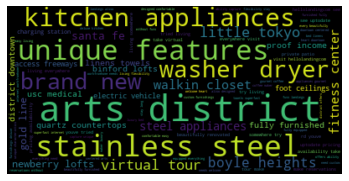

In [86]:
print("Boyle Heights Word Cloud") 
wordcloud = WordCloud().generate(string_bohe500_nosword)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [87]:
string_ktown500_nosword = [word for word in word_tokenize(str_ktown500.lower()) if word not in swords]
string_ktown500_nosword = str(string_ktown500_nosword)
string_ktown500_nosword = re.sub(r"[^A-z\s]", "", string_ktown500_nosword)
string_ktown500_nosword = re.sub(r"\s+", " ", string_ktown500_nosword)

Koreatown Word Cloud


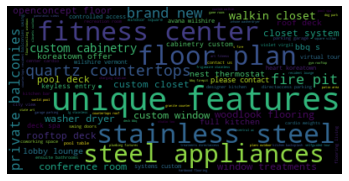

In [88]:
print("Koreatown Word Cloud") 
wordcloud = WordCloud().generate(string_ktown500_nosword)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [89]:
string_hipa500_nosword = [word for word in word_tokenize(str_hipa500.lower()) if word not in swords]
string_hipa500_nosword = str(string_hipa500_nosword)
string_hipa500_nosword = re.sub(r"[^A-z\s]", "", string_hipa500_nosword)
string_hipa500_nosword = re.sub(r"\s+", " ", string_hipa500_nosword)

Highland Park Word Cloud


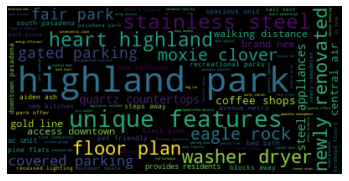

In [92]:
print("Highland Park Word Cloud") 
wordcloud = WordCloud().generate(string_hipa500_nosword)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [104]:
string_nosword = pd.DataFrame([string_eho500_nosword, string_bohe500_nosword, string_ktown500_nosword, string_hipa500_nosword])

string_nosword.to_csv('C:/Users/audre/OneDrive/Documents/229-GitHub/string_nosword.csv') 

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 3. Topic Modeling Descriptions

Honestly, no insights were derived from a bunch of topic models derived... I think I'll give up on this method of analysis for the final submission. 

In [93]:
import gensim
import pyLDAvis
import pyLDAvis.gensim_models   # note that in previous versions this was called pyLDAvis.gensim

#### East Hollywood Topic Modeling

In [94]:
#East Hollywood 
wordlists_e = [[word for word in word_tokenize(string_eho500_nosword.lower()) if word not in swords]] 

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
# DO NOT RUN CELL AGAIN - Default East Hollywood Topic Modeling 

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.004894  0.001590       1        1  45.098630
6     -0.002296 -0.001358       2        1  17.221238
7     -0.002464  0.000796       3        1  15.963627
4     -0.001667 -0.002652       4        1  11.584112
0     -0.000854 -0.000443       5        1   5.808879
2      0.000980  0.001957       6        1   2.258045
8      0.002216  0.000255       7        1   0.636990
5      0.002805 -0.000030       8        1   0.586845
1      0.002556  0.000144       9        1   0.475704
9      0.003617 -0.000260      10        1   0.365931, topic_info=           Term        Freq       Total Category  logprob  loglift
282   community  667.000000  667.000000  Default  30.0000  30.0000
682   hollywood  452.000000  452.000000  Default  29.0000  29.0000
522    features  429.000000  429.000000  Default  28.0000  28.0000
944         new  378.000000  378.000000  Default  27.0000  27.0000
1021    parking  406.000000  406.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
578        free    0.926815  388.449464  Topic10  -5.5467  -0.4277
544     fitness    0.751800  255.632654  Topic10  -5.7559  -0.2185
1243     shared    0.808996  310.285703  Topic10  -5.6826  -0.3390
1322  stainless    0.822520  331.802303  Topic10  -5.6660  -0.3894
41    amenities    0.716707  237.798362  Topic10  -5.8037  -0.1940

[828 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
6         1  0.355475  abode
6         2  0.203128  abode
6         3  0.203128  abode
6         4  0.152346  abode
6         5  0.050782  abode
...     ...       ...    ...
1604      2  0.186017  youve
1604      3  0.186017  youve
1604      4  0.139513  youve
1604      5  0.046504  youve
1604      6  0.046504  youve

[2577 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 8, 5, 1, 3, 9, 6, 2, 10])

In [99]:
#reduce number of topics to 4 

dictionary_e = gensim.corpora.Dictionary(wordlists_e)
corpus_e = [dictionary_e.doc2bow(wl) for wl in wordlists_e]
model_e = gensim.models.LdaMulticore(corpus_e, id2word=dictionary_e, num_topics=4, alpha = 0.9, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_e, corpus_e, dictionary_e)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.003617  0.000219       1        1  50.302000
0     -0.000014 -0.002947       2        1  26.375375
2     -0.000422  0.002304       3        1  14.554774
1      0.004054  0.000425       4        1   8.767852, topic_info=           Term        Freq       Total Category  logprob  loglift
282   community  687.000000  687.000000  Default  30.0000  30.0000
682   hollywood  508.000000  508.000000  Default  29.0000  29.0000
944         new  399.000000  399.000000  Default  28.0000  28.0000
1243     shared  326.000000  326.000000  Default  27.0000  27.0000
1021    parking  403.000000  403.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
764    kitchens   18.947420  212.660815   Topic4  -5.7054   0.0160
1474       unit   21.566410  330.194266   Topic4  -5.5759  -0.2945
1020       park   20.430081  282.984032   Topic4  -5.6301  -0.1943
10       access   19.502759  285.019611   Topic4  -5.6765  -0.2479
188   cabinetry   19.178259  254.966676   Topic4  -5.6933  -0.1533

[328 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
8         1  0.495545      ac
8         2  0.241076      ac
8         3  0.147324      ac
8         4  0.120538      ac
9         1  0.353741  accent
...     ...       ...     ...
1584      4  0.104724    wood
1601      1  0.515481    york
1601      2  0.257741    york
1601      3  0.257741    york
1601      4  0.257741    york

[840 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [100]:
#reduce alpha values for greater differentiation between topics 

dictionary_e = gensim.corpora.Dictionary(wordlists_e)
corpus_e = [dictionary_e.doc2bow(wl) for wl in wordlists_e]
model_e = gensim.models.LdaMulticore(corpus_e, id2word=dictionary_e, num_topics=4, alpha = 0.4, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_e, corpus_e, dictionary_e)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.003669 -0.002382       1        1  58.773207
3      0.002367  0.003179       2        1  29.306909
2     -0.002010 -0.000991       3        1   8.804019
1     -0.004026  0.000194       4        1   3.115864, topic_info=            Term        Freq       Total Category  logprob  loglift
282    community  680.000000  680.000000  Default  30.0000  30.0000
522     features  456.000000  456.000000  Default  29.0000  29.0000
682    hollywood  533.000000  533.000000  Default  28.0000  28.0000
1334       steel  305.000000  305.000000  Default  27.0000  27.0000
1098     private  426.000000  426.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
62    appliances    8.593689  397.296006   Topic4  -5.4615  -0.3650
816       living    7.830737  319.559548   Topic4  -5.5544  -0.2402
1243      shared    7.621268  361.924979   Topic4  -5.5815  -0.3918
188    cabinetry    6.835317  261.053440   Topic4  -5.6904  -0.1740
364         deck    6.531877  240.566147   Topic4  -5.7358  -0.1376

[343 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5         1  0.457427  ability
5         2  0.406602  ability
5         3  0.101651  ability
5         4  0.050825  ability
10        1  0.587102   access
...     ...       ...      ...
1568      2  0.246816     wifi
1568      3  0.061704     wifi
1568      4  0.041136     wifi
1582      1  0.561393  wmirror
1582      2  0.280697  wmirror

[778 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [101]:
#alpha values for greater differentiation between the words within the topics 

dictionary_e = gensim.corpora.Dictionary(wordlists_e)
corpus_e = [dictionary_e.doc2bow(wl) for wl in wordlists_e]
model_e = gensim.models.LdaMulticore(corpus_e, id2word=dictionary_e, num_topics=4, alpha = 0.9, eta=0.4)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_e, corpus_e, dictionary_e)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003792  0.000699       1        1  34.610761
3      0.001502 -0.003171       2        1  28.363166
1     -0.000471 -0.000182       3        1  19.189561
2      0.002760  0.002654       4        1  17.836513, topic_info=            Term        Freq       Total Category  logprob  loglift
685         home  383.000000  383.000000  Default  30.0000  30.0000
1322   stainless  327.000000  327.000000  Default  29.0000  29.0000
1195        room  321.000000  321.000000  Default  28.0000  28.0000
1243      shared  343.000000  343.000000  Default  27.0000  27.0000
62    appliances  373.000000  373.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1474        unit   48.212674  327.938894   Topic4  -5.4816  -0.1933
909       modern   42.766312  243.714922   Topic4  -5.6015  -0.0163
1334       steel   47.051065  340.873204   Topic4  -5.5060  -0.2564
10        access   43.482288  289.364180   Topic4  -5.5849  -0.1714
593    furnished   42.867499  277.843576   Topic4  -5.5991  -0.1450

[314 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
10        1  0.355953    access
10        2  0.307571    access
10        3  0.186616    access
10        4  0.148602    access
17        1  0.320771    actual
...     ...       ...       ...
1585      4  0.157399  woodlike
1603      1  0.424323     youll
1603      2  0.243986     youll
1603      3  0.201553     youll
1603      4  0.137905     youll

[772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [102]:
#3 topics, with low alpha values 

dictionary_e = gensim.corpora.Dictionary(wordlists_e)
corpus_e = [dictionary_e.doc2bow(wl) for wl in wordlists_e]
model_e = gensim.models.LdaMulticore(corpus_e, id2word=dictionary_e, num_topics=2, alpha = 0.2, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_e, corpus_e, dictionary_e)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003052  0.0       1        1  57.790609
0     -0.003052  0.0       2        1  42.209391, topic_info=           Term        Freq       Total Category  logprob  loglift
1322  stainless  334.000000  334.000000  Default  30.0000  30.0000
10       access  284.000000  284.000000  Default  29.0000  29.0000
1342    storage  241.000000  241.000000  Default  28.0000  28.0000
1159       rent  300.000000  300.000000  Default  27.0000  27.0000
76         area  231.000000  231.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
578        free  149.729705  421.256383   Topic2  -5.2098  -0.1719
1195       room  125.413636  326.381642   Topic2  -5.3870  -0.0939
1474       unit  124.649454  325.406770   Topic2  -5.3931  -0.0970
364        deck  100.248580  240.126190   Topic2  -5.6110  -0.0110
188   cabinetry   98.752042  256.461497   Topic2  -5.6260  -0.0918

[181 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
10        1  0.463393       access
10        2  0.533604       access
41        1  0.621135    amenities
41        2  0.377717    amenities
44        1  0.452382  amenityrich
...     ...       ...          ...
1526      2  0.482920            w
1566      1  0.737759         wide
1566      2  0.257358         wide
1568      1  0.502833         wifi
1568      2  0.496038         wifi

[258 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

#### Boyle Heights Topic Modeling 

In [105]:
#Boyle Heights
wordlists_b = [[word for word in word_tokenize(string_bohe500_nosword.lower()) if word not in swords]] 

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
# default topic modeling
dictionary_b = gensim.corpora.Dictionary(wordlists_b)
corpus_b = [dictionary_b.doc2bow(wl) for wl in wordlists_b]
model_b = gensim.models.LdaMulticore(corpus_b, id2word=dictionary_b, num_topics=10, alpha = 0.9, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_b, corpus_b, dictionary_b)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.004899  0.002768       1        1  45.713395
6     -0.005506 -0.002353       2        1  41.992110
2     -0.000487  0.001753       3        1   3.524812
1      0.000152 -0.001655       4        1   2.655341
3     -0.000476 -0.001860       5        1   2.569902
0     -0.000448  0.000397       6        1   2.303134
7      0.001327  0.000256       7        1   0.486947
5      0.001628  0.000429       8        1   0.437935
4      0.002163  0.000403       9        1   0.299011
9      0.006546 -0.000138      10        1   0.017415, topic_info=            Term        Freq       Total Category  logprob  loglift
618          new  318.000000  318.000000  Default  30.0000  30.0000
958         unit  285.000000  285.000000  Default  29.0000  29.0000
258     downtown  245.000000  245.000000  Default  28.0000  28.0000
245     district  288.000000  288.000000  Default  27.0000  27.0000
531       living  274.000000  274.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
855    stainless    0.018499  164.739825  Topic10  -5.8361  -0.4388
7         access    0.017750  156.006732  Topic10  -5.8774  -0.4256
534     location    0.016190  115.070316  Topic10  -5.9694  -0.2133
357     flooring    0.016028  132.769690  Topic10  -5.9795  -0.3664
758  restaurants    0.015895  162.547710  Topic10  -5.9878  -0.5771

[839 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.459080        [
0         2  0.459080        [
2         1  0.465305        ]
2         2  0.310203        ]
7         1  0.371779   access
...     ...       ...      ...
1038      6  0.020817     year
1042      1  0.358991  you\\re
1042      2  0.358991  you\\re
1043      1  0.360148  you\\ve
1043      2  0.360148  you\\ve

[1553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 3, 2, 4, 1, 8, 6, 5, 10])

In [108]:

dictionary_b = gensim.corpora.Dictionary(wordlists_b)
corpus_b = [dictionary_b.doc2bow(wl) for wl in wordlists_b]
model_b = gensim.models.LdaMulticore(corpus_b, id2word=dictionary_b, num_topics=2, alpha = 0.9, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_b, corpus_b, dictionary_b)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003538  0.0       1        1  72.379073
0     -0.003538  0.0       2        1  27.620927, topic_info=          Term        Freq       Total Category  logprob  loglift
957     unique  229.000000  229.000000  Default  30.0000  30.0000
958       unit  279.000000  279.000000  Default  29.0000  29.0000
618        new  346.000000  346.000000  Default  28.0000  28.0000
332   features  201.000000  201.000000  Default  27.0000  27.0000
531     living  305.000000  305.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
879     street   36.782835  142.375197   Topic2  -5.6100  -0.0668
268       dtla   33.602540  122.538021   Topic2  -5.7005  -0.0072
377       full   34.256998  137.043984   Topic2  -5.6812  -0.0998
855  stainless   35.727900  161.771968   Topic2  -5.6391  -0.2237
714   property   35.159637  164.097766   Topic2  -5.6552  -0.2540

[169 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
7         1  0.709299     access
7         2  0.290168     access
19        1  0.608013      adult
19        2  0.386918      adult
24        1  0.605211     alisos
...     ...       ...        ...
1029      2  0.218030  wonderful
1038      1  0.815661       year
1038      2  0.190899       year
1041      1  0.785825    you\\ll
1041      2  0.206796    you\\ll

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

#### Koreatown Topic Modeling 

In [110]:
#Koreatown
wordlists_k = [[word for word in word_tokenize(string_ktown500_nosword.lower()) if word not in swords]] 

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
dictionary_k = gensim.corpora.Dictionary(wordlists_k)
corpus_k = [dictionary_k.doc2bow(wl) for wl in wordlists_k]
model_k = gensim.models.LdaMulticore(corpus_k, id2word=dictionary_k, num_topics=10, alpha = 0.2, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_k, corpus_k, dictionary_k)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.004265  0.000952       1        1  37.682040
8     -0.002355 -0.003040       2        1  20.102500
2     -0.002281  0.002164       3        1  17.726924
0     -0.000933 -0.000648       4        1  11.105030
9     -0.000146 -0.000167       5        1   5.240844
4      0.001454  0.000634       6        1   3.581474
1      0.001326 -0.000320       7        1   1.664075
6      0.002495  0.001157       8        1   1.146361
3      0.001976  0.000228       9        1   1.089378
7      0.002730 -0.000961      10        1   0.661375, topic_info=             Term        Freq       Total Category  logprob  loglift
765     koreatown  559.000000  559.000000  Default  30.0000  30.0000
1210         room  455.000000  455.000000  Default  29.0000  29.0000
355        custom  516.000000  516.000000  Default  28.0000  28.0000
1495       unique  449.000000  449.000000  Default  27.0000  27.0000
521      features  390.000000  390.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
376      designer    1.697897  312.088008  Topic10  -5.4932  -0.1953
321   countertops    1.528699  278.870145  Topic10  -5.5981  -0.1877
952           new    1.565448  296.667282  Topic10  -5.5744  -0.2258
1597     wilshire    1.550412  311.700027  Topic10  -5.5840  -0.2849
361          deck    1.492255  318.349697  Topic10  -5.6223  -0.3443

[817 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
7         1  0.405171     ac
7         2  0.175574     ac
7         3  0.148563     ac
7         4  0.121551     ac
7         5  0.067528     ac
...     ...       ...    ...
1632      2  0.238695  youll
1632      3  0.143217  youll
1632      4  0.143217  youll
1632      5  0.047739  youll
1632      6  0.047739  youll

[3027 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 3, 1, 10, 5, 2, 7, 4, 8])

In [114]:
dictionary_k = gensim.corpora.Dictionary(wordlists_k)
corpus_k = [dictionary_k.doc2bow(wl) for wl in wordlists_k]
model_k = gensim.models.LdaMulticore(corpus_k, id2word=dictionary_k, num_topics=2, alpha = 0.2, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_k, corpus_k, dictionary_k)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.002942  0.0       1        1  56.30724
0     -0.002942  0.0       2        1  43.69276, topic_info=          Term        Freq       Total Category  logprob  loglift
1538     views  394.000000  394.000000  Default  30.0000  30.0000
1360     steel  273.000000  273.000000  Default  29.0000  29.0000
975   offering  107.000000  107.000000  Default  28.0000  28.0000
1114   private  322.000000  322.000000  Default  27.0000  27.0000
1498     units  374.000000  374.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
758    kitchen  152.895874  388.418516   Topic2  -5.1834  -0.1043
952        new  133.124538  315.463080   Topic2  -5.3219  -0.0348
218     center  137.032566  333.089253   Topic2  -5.2930  -0.0602
1495    unique  168.895705  495.990721   Topic2  -5.0839  -0.2493
1375    studio  117.633338  284.159295   Topic2  -5.4456  -0.0540

[180 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4         1  0.468859       abbey
4         2  0.530551       abbey
46        1  0.570359   amenities
46        2  0.427769   amenities
60        1  0.607277  appliances
...     ...       ...         ...
1614      2  0.518564        wood
1633      1  0.468855       youre
1633      2  0.625141       youre
1634      1  0.695990        zion
1634      2  0.347995        zion

[252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

#### Highland Park Topic Modeling 

In [115]:
#Highland Park
wordlists_h = [[word for word in word_tokenize(string_hipa500_nosword.lower()) if word not in swords]] 

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
dictionary_h = gensim.corpora.Dictionary(wordlists_h)
corpus_h = [dictionary_h.doc2bow(wl) for wl in wordlists_h]
model_h = gensim.models.LdaMulticore(corpus_h, id2word=dictionary_h, num_topics=10, alpha = 0.2, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_h, corpus_h, dictionary_h)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.005365  0.002137       1        1  58.025508
4      0.003537 -0.003358       2        1  19.966603
9      0.001694  0.000101       3        1  10.949866
8      0.001422  0.001166       4        1   6.900195
0     -0.000337 -0.001265       5        1   2.085635
7     -0.001246 -0.000343       6        1   0.941190
1     -0.001196  0.000223       7        1   0.506465
2     -0.001702  0.001654       8        1   0.452261
3     -0.003444 -0.000731       9        1   0.121215
5     -0.004094  0.000416      10        1   0.051061, topic_info=             Term        Freq       Total Category  logprob  loglift
582           new  671.000000  671.000000  Default  30.0000  30.0000
630          park  660.000000  660.000000  Default  29.0000  29.0000
419      highland  448.000000  448.000000  Default  28.0000  28.0000
915          unit  448.000000  448.000000  Default  27.0000  27.0000
320      features  274.000000  274.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
914        unique    0.076411  237.079052  Topic10  -5.5810  -0.4601
346      flooring    0.078844  260.046757  Topic10  -5.5496  -0.5212
481       laundry    0.072764  220.067202  Topic10  -5.6299  -0.4346
2              ac    0.063685  148.782448  Topic10  -5.7631  -0.1764
578  neighborhood    0.063711  195.465185  Topic10  -5.7627  -0.4489

[797 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.464659        [
0         2  0.154886        [
0         3  0.154886        [
0         4  0.154886        [
1         1  0.469617        ]
...     ...       ...      ...
993       4  0.085861  you\\re
993       5  0.028620  you\\re
994       1  0.534042  you\\ve
994       2  0.178014  you\\ve
994       3  0.178014  you\\ve

[1527 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 10, 9, 1, 8, 2, 3, 4, 6])

In [117]:
dictionary_h = gensim.corpora.Dictionary(wordlists_h)
corpus_h = [dictionary_h.doc2bow(wl) for wl in wordlists_h]
model_h = gensim.models.LdaMulticore(corpus_h, id2word=dictionary_h, num_topics=2, alpha = 0.2, eta=0.9)
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model_h, corpus_h, dictionary_h)

C:\Users\audre\anaconda3\envs\up229\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003222  0.0       1        1  60.535214
0     -0.003222  0.0       2        1  39.464786, topic_info=             Term        Freq       Total Category  logprob  loglift
427          home  229.000000  229.000000  Default  30.0000  30.0000
915          unit  490.000000  490.000000  Default  29.0000  29.0000
578  neighborhood  193.000000  193.000000  Default  28.0000  28.0000
205   countertops  139.000000  139.000000  Default  27.0000  27.0000
164        clover   90.000000   90.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
481       laundry   75.167182  215.337518   Topic2  -5.3398  -0.1227
598        offers   73.196868  227.667639   Topic2  -5.3663  -0.2050
346      flooring   73.424196  234.689069   Topic2  -5.3632  -0.2322
584         newly   65.892034  203.480037   Topic2  -5.4715  -0.1978
723     renovated   61.334778  165.835359   Topic2  -5.5431  -0.0649

[169 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
2         1  0.582295                    ac
2         2  0.418525                    ac
3         1  0.589230                access
3         2  0.412461                access
15        1  0.553904                   air
...     ...       ...                   ...
985       2  0.564205  wwwblackpineflatscom
992       1  0.486473               you\\ll
992       2  0.509639               you\\ll
995       1  0.695342               younger
995       2  0.298004               younger

[228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## 4. Rents Analysis (TBD) 

Sara and I were thinking maybe do a scatterplot of median rents or rents per SF and the frequency of each gentrification keyword? We need some help narrowing this scope down to something feasible in the final weeks of the quarter. 

Thank you and we look forward to your comments! 